## LLM Final Assessment
### Jason Clibanoff

In [29]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#word text libraries
from textblob import TextBlob
import nltk
from nltk.corpus import opinion_lexicon
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize, word_tokenize
from transformers import pipeline
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#sklearn libraries
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV

In [30]:
#create and preview df
df = pd.read_csv("test(in).csv")
df.head()

,Subject,body,date,from
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,5/10/2010,sally.beck@enron.com
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",7/25/2011,sally.beck@enron.com
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,3/25/2010,johnny.palmer@enron.com
4,Bet,Since you never gave me the $20 for the last t...,5/21/2011,lydia.delgado@enron.com


### 1. Sentiment Labeling

**using textblobs**

My first attempt at calculating the sentiment was with textblobs, however it may not have been the best method as it can over represent neutral or otherwise misrepresent sentiment by missing subtleties.

In [76]:
'''
def categorize_sentiment(subject, body):
    #extract sentiment from both the subject and body using textblobs
    subject_sentiment = TextBlob(subject).sentiment.polarity
    body_sentiment = TextBlob(body).sentiment.polarity    
    avg_sentiment = (subject_sentiment + body_sentiment) / 2 
    
    if avg_sentiment > 0:
        return "Positive"
    elif avg_sentiment < 0:
        return "Negative"
    else:
        return "Neutral"
'''

'\ndef categorize_sentiment(subject, body):\n    #extract sentiment from both the subject and body using textblobs\n    subject_sentiment = TextBlob(subject).sentiment.polarity\n    body_sentiment = TextBlob(body).sentiment.polarity    \n    avg_sentiment = (subject_sentiment + body_sentiment) / 2 \n    \n    if avg_sentiment > 0:\n        return "Positive"\n    elif avg_sentiment < 0:\n        return "Negative"\n    else:\n        return "Neutral"\n'

In [77]:
'''
df["sentiment"] = df.apply(lambda row: categorize_sentiment(row['Subject'], row['body']), axis = 1)
df.head()
'''

'\ndf["sentiment"] = df.apply(lambda row: categorize_sentiment(row[\'Subject\'], row[\'body\']), axis = 1)\ndf.head()\n'

**using bert transformer**

Next I tried using the sentiment-analysis pipeline featuring Bert, but this also proved to not be very effective.
This method is better suited to longer bodies of text rather than short emails, only outputs a binary positive or negative, and in this case vastly overrepresented negative sentiment.

In [78]:
'''
#load in the pipeline for sentiment analysis
sentiment_pipeline = pipeline("sentiment-analysis")
'''


'\n#load in the pipeline for sentiment analysis\nsentiment_pipeline = pipeline("sentiment-analysis")\n'

In [79]:
'''
#create a function using the transformer to categorize the sentiment of the subject and body

def categorize_sentiment_bert(subject, body):
    combined_text = f"{subject} {body}"
    result = sentiment_pipeline(combined_text)[0]
    label = result["label"]
    
    if label == "POSITIVE":
        return "Positive"
    elif label == "NEGATIVE":
        return "Negative"
    else:
        return "Neutral"
        '''

'\n#create a function using the transformer to categorize the sentiment of the subject and body\n\ndef categorize_sentiment_bert(subject, body):\n    combined_text = f"{subject} {body}"\n    result = sentiment_pipeline(combined_text)[0]\n    label = result["label"]\n    \n    if label == "POSITIVE":\n        return "Positive"\n    elif label == "NEGATIVE":\n        return "Negative"\n    else:\n        return "Neutral"\n        '

In [80]:
'''
df["sentiment"] = df.apply(lambda row: categorize_sentiment_bert(row['Subject'], row['body']), axis = 1)
df.head()
'''

'\ndf["sentiment"] = df.apply(lambda row: categorize_sentiment_bert(row[\'Subject\'], row[\'body\']), axis = 1)\ndf.head()\n'

**using vader**

VaderSentiment proved to be most effective. It is better suited to short form text, like that of an email, as it is more finely tuned to handle short, informal, sentence level texts.

In [81]:
analyzer = SentimentIntensityAnalyzer()

def categorize_sentiment_vader(subject, body):
    combined_text = f"{subject} {body}"
    score = analyzer.polarity_scores(combined_text)["compound"]

    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

In [82]:
df["sentiment"] = df.apply(lambda row: categorize_sentiment_vader(row['Subject'], row['body']), axis = 1)
df.head()

,Subject,body,date,from,sentiment,sentiment score,subject_pos_pct,subject_neg_pct,subject_pos_count,subject_neg_count,subject_total_words,body_pos_pct,body_neg_pct,body_pos_count,body_neg_count,body_total_words
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com,Positive,1,0.000000,0.0,0.0,0.0,3.0,0.877193,0.000000,1.0,0.0,114.0
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com,Positive,1,0.000000,0.0,0.0,0.0,4.0,3.030303,1.515152,2.0,1.0,66.0
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com,Neutral,0,0.000000,0.0,0.0,0.0,7.0,0.000000,0.000000,0.0,0.0,50.0
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com,Neutral,0,16.666667,0.0,1.0,0.0,6.0,0.000000,0.000000,0.0,0.0,30.0
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com,Positive,1,0.000000,0.0,0.0,0.0,1.0,0.000000,0.000000,0.0,0.0,46.0


### 2. Exploratory Data Analysis

In [38]:
df.shape

(2191, 5)

In [39]:
df.describe()

,Subject,body,date,from,sentiment
count,2191,2191,2191,2191,2191
unique,1251,1539,690,10,3
top,(No Subject),\n\n,7/1/2011,lydia.delgado@enron.com,Positive
freq,141,21,9,284,1574


In [40]:
df.dtypes

Subject      object
body         object
date         object
from         object
sentiment    object
dtype: object

In [41]:
#convert date to datetime
df['date'] = pd.to_datetime(df['date'], format = '%m/%d/%Y')
print(df.dtypes)
df.head()

Subject              object
body                 object
date         datetime64[ns]
from                 object
sentiment            object
dtype: object


,Subject,body,date,from,sentiment
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com,Positive
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com,Positive
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com,Neutral
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com,Neutral
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com,Positive


In [42]:
df['sentiment'].value_counts()

sentiment
Positive    1574
Neutral      444
Negative     173
Name: count, dtype: int64

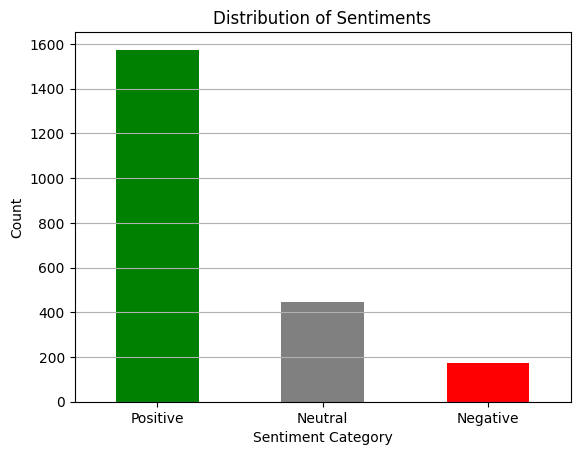

In [43]:
#count occurrences of each sentiment category
sentiment_counts = df['sentiment'].value_counts()

#plot bar graph
plt.figure()
sentiment_counts.plot(kind='bar', color=['green', 'gray', 'red'])
plt.xlabel("Sentiment Category")
plt.ylabel("Count")
plt.title("Distribution of Sentiments")
plt.xticks(rotation=0)
plt.grid(axis='y')

#show/save the plot
plt.savefig('Distribution of Sentiments.png')
plt.show()

In [44]:
sentiments_gb = df.groupby(['from', 'sentiment']).size().reset_index(name='count')


In [45]:
sentiments_pivot = sentiments_gb.pivot(index='from', columns='sentiment', values='count').fillna(0)
sentiments_pivot.sort_values(by = ['Positive', 'Negative', 'Neutral'], ascending = False, inplace = True)
sentiments_pivot

sentiment,Negative,Neutral,Positive
from,,,
lydia.delgado@enron.com,16,64,204
john.arnold@enron.com,12,53,191
patti.thompson@enron.com,20,38,167
eric.bass@enron.com,15,35,160
sally.beck@enron.com,25,43,159
johnny.palmer@enron.com,21,41,151
bobette.riner@ipgdirect.com,23,45,149
don.baughman@enron.com,13,52,148
kayne.coulter@enron.com,18,33,123


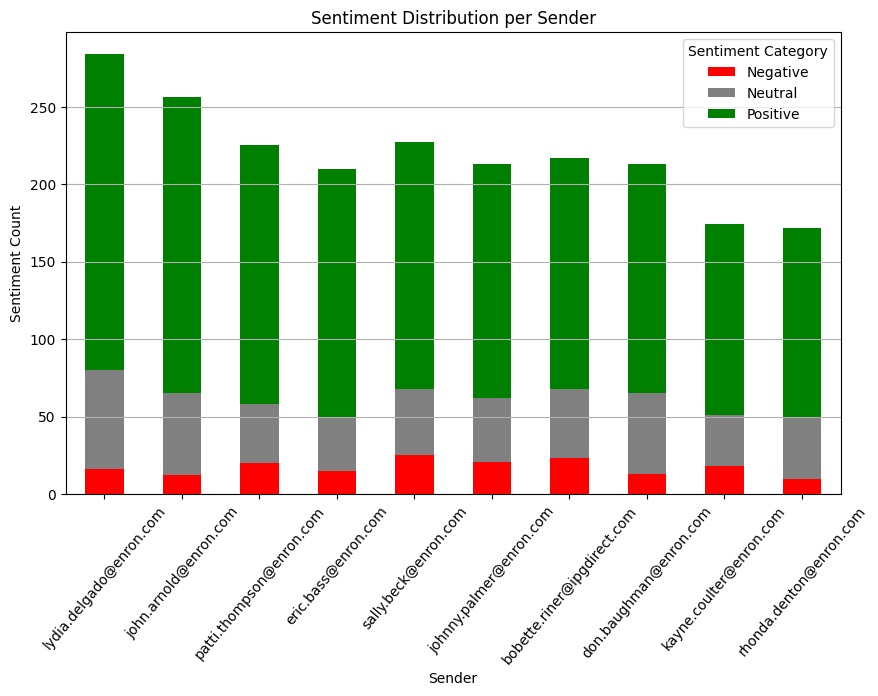

In [46]:
sentiments_pivot.plot(kind='bar', stacked=True, figsize=(10, 6), color={'Positive': 'green', 'Neutral': 'gray', 'Negative': 'red'})
plt.xlabel("Sender")
plt.ylabel("Sentiment Count")
plt.title("Sentiment Distribution per Sender")
plt.xticks(rotation = 50)
plt.legend(title = "Sentiment Category")
plt.grid(axis='y')
plt.savefig("Sentiment Distribution per Sender.png")

In [47]:
#function to give a sentiment score to each entry
def get_sentiment_score(sentiment):
    if sentiment == 'Positive':
        return 1
    elif sentiment == 'Negative':
        return -1
    else:
        return 0     
df['sentiment score'] = df.apply(lambda row: get_sentiment_score(row['sentiment']), axis = 1)
df.head()

,Subject,body,date,from,sentiment,sentiment score
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com,Positive,1
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com,Positive,1
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com,Neutral,0
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com,Neutral,0
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com,Positive,1


In [48]:
#group by month, from(email address), and sentiment, then make pivot table with montha sindex for easy access to monthly data
monthly_sentiments = df.groupby([df['date'].dt.to_period('M'), 'from', 'sentiment']).size().reset_index(name='count')

monthly_pivot = monthly_sentiments.pivot(index=['date', 'from'], columns='sentiment', values='count').fillna(0)
monthly_pivot

sentiment                            Negative  Neutral  Positive
date    from                                                    
2010-01 bobette.riner@ipgdirect.com       0.0      1.0       1.0
        don.baughman@enron.com            0.0      1.0       8.0
        eric.bass@enron.com               0.0      1.0       9.0
        john.arnold@enron.com             0.0      2.0       5.0
        johnny.palmer@enron.com           1.0      1.0       4.0
...                                       ...      ...       ...
2011-12 kayne.coulter@enron.com           0.0      1.0       8.0
        lydia.delgado@enron.com           1.0      4.0      12.0
        patti.thompson@enron.com          0.0      0.0      12.0
        rhonda.denton@enron.com           0.0      3.0       8.0
        sally.beck@enron.com              0.0      3.0       6.0

[240 rows x 3 columns]

In [49]:
monthly_sentiments.head()

,date,from,sentiment,count
0,2010-01,bobette.riner@ipgdirect.com,Neutral,1
1,2010-01,bobette.riner@ipgdirect.com,Positive,1
2,2010-01,don.baughman@enron.com,Neutral,1
3,2010-01,don.baughman@enron.com,Positive,8
4,2010-01,eric.bass@enron.com,Neutral,1


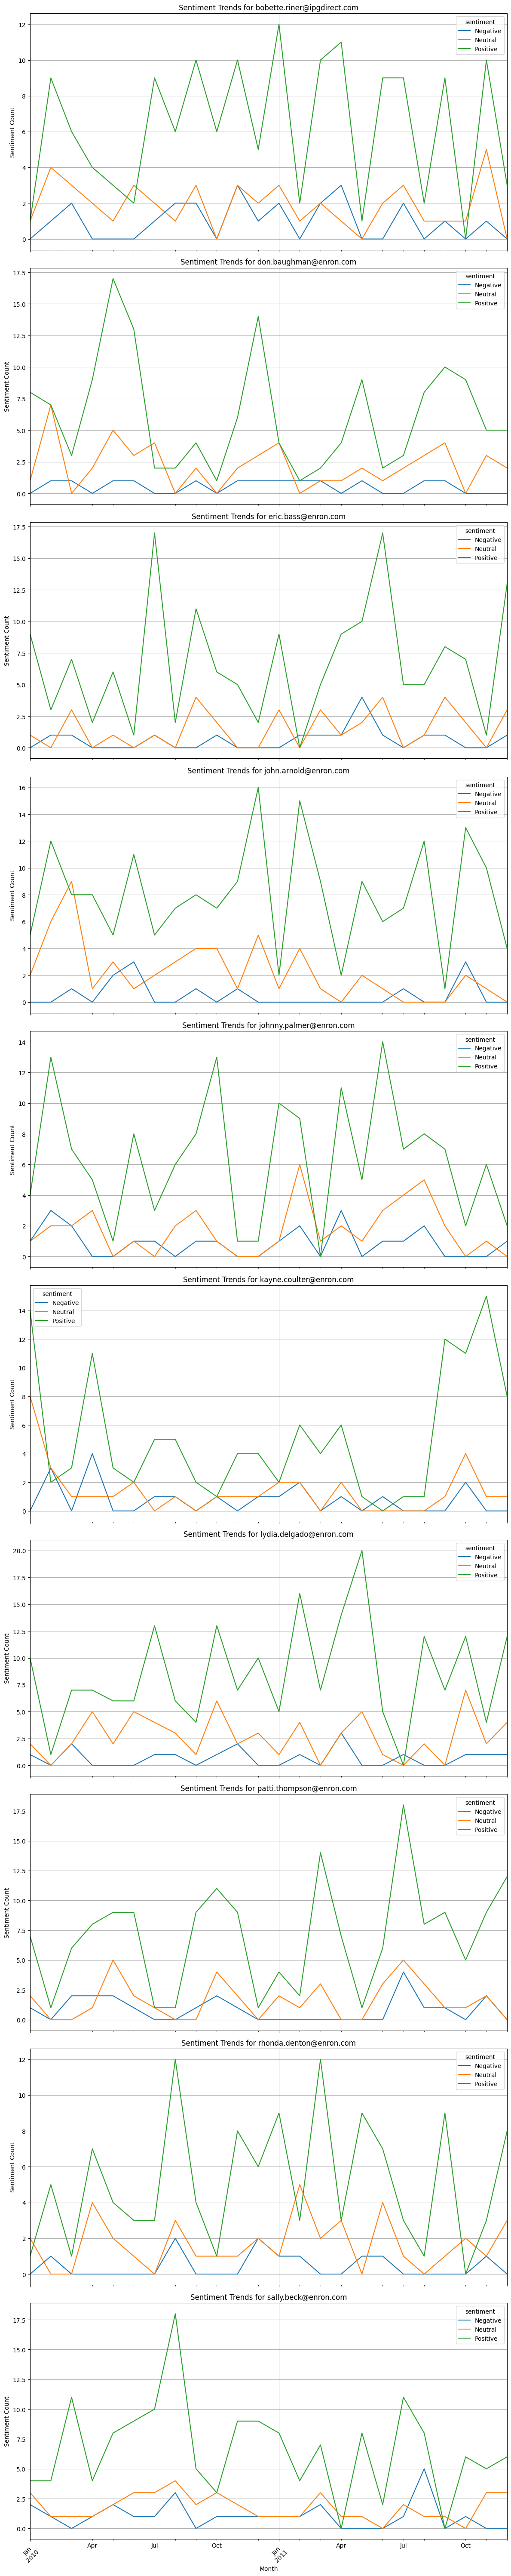

In [50]:
#plot sentiment trends for each email address
senders = monthly_pivot.index.get_level_values('from').unique()
fig, axes = plt.subplots(len(senders), 1, figsize=(12, 6 * len(senders)), sharex=True)

for ax, sender in zip(axes, senders):
    monthly_pivot.xs(sender, level='from').plot(kind='line', linestyle='-', ax=ax)
    ax.set_title(f"Sentiment Trends for {sender}")
    ax.set_ylabel("Sentiment Count")
    ax.grid(True)

#set labels
plt.xlabel("Month")
plt.xticks(rotation=45)

#display
plt.tight_layout()
plt.show()


### 3. Calculate Sentiment Scores

In [51]:
#function to give a sentiment score to each entry
def get_sentiment_score(sentiment):
    if sentiment == 'Positive':
        return 1
    elif sentiment == 'Negative':
        return -1
    else:
        return 0     


In [52]:
df['sentiment score'] = df.apply(lambda row: get_sentiment_score(row['sentiment']), axis = 1)
df.head()

,Subject,body,date,from,sentiment,sentiment score
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com,Positive,1
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com,Positive,1
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com,Neutral,0
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com,Neutral,0
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com,Positive,1


In [53]:
#to calculate the score for each month, I use a pivot table where the month is the index, 
#and add 1 for positive and -1 for negative, ignoring neutral because it adds 0 points. 
monthly_pivot['Monthly Sentiment Score'] = (monthly_pivot['Positive'] * 1 + monthly_pivot['Negative'] * -1)
monthly_pivot                                 

sentiment                            Negative  Neutral  Positive  \
date    from                                                       
2010-01 bobette.riner@ipgdirect.com       0.0      1.0       1.0   
        don.baughman@enron.com            0.0      1.0       8.0   
        eric.bass@enron.com               0.0      1.0       9.0   
        john.arnold@enron.com             0.0      2.0       5.0   
        johnny.palmer@enron.com           1.0      1.0       4.0   
...                                       ...      ...       ...   
2011-12 kayne.coulter@enron.com           0.0      1.0       8.0   
        lydia.delgado@enron.com           1.0      4.0      12.0   
        patti.thompson@enron.com          0.0      0.0      12.0   
        rhonda.denton@enron.com           0.0      3.0       8.0   
        sally.beck@enron.com              0.0      3.0       6.0   

sentiment                            Monthly Sentiment Score  
date    from                                                  
2010-01 bobette.riner@ipgdirect.com                      1.0  
        don.baughman@enron.com                           8.0  
        eric.bass@enron.com                              9.0  
        john.arnold@enron.com                            5.0  
        johnny.palmer@enron.com                          3.0  
...                                                      ...  
2011-12 kayne.coulter@enron.com                          8.0  
        lydia.delgado@enron.com                         11.0  
        patti.thompson@enron.com                        12.0  
        rhonda.denton@enron.com                          8.0  
        sally.beck@enron.com                             6.0  

[240 rows x 4 columns]

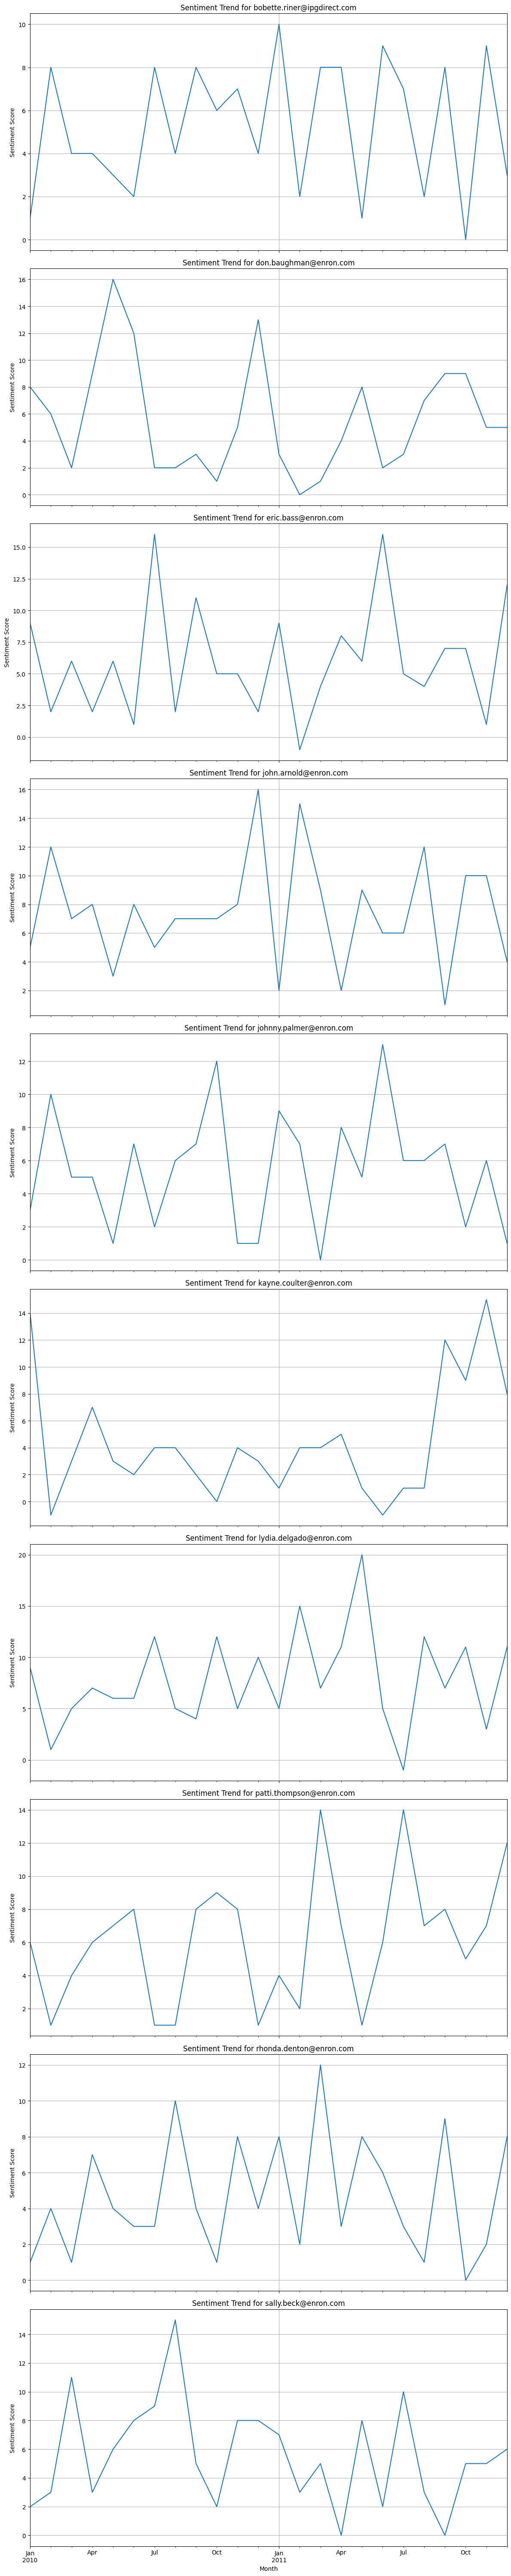

In [54]:
#make plots of each employee's monthly sentiment scores over time
fig, axes = plt.subplots(len(senders), 1, figsize=(12, 6 * len(senders)), sharex=True)

for ax, sender in zip(axes, senders):
    monthly_pivot.xs(sender, level='from')['Monthly Sentiment Score'].plot(linestyle='-', ax = ax)
    ax.set_title(f"Sentiment Trend for {sender}")
    ax.set_ylabel("Sentiment Score")
    ax.grid(True)

plt.xlabel("Month")

#display plots
plt.tight_layout()
plt.show()

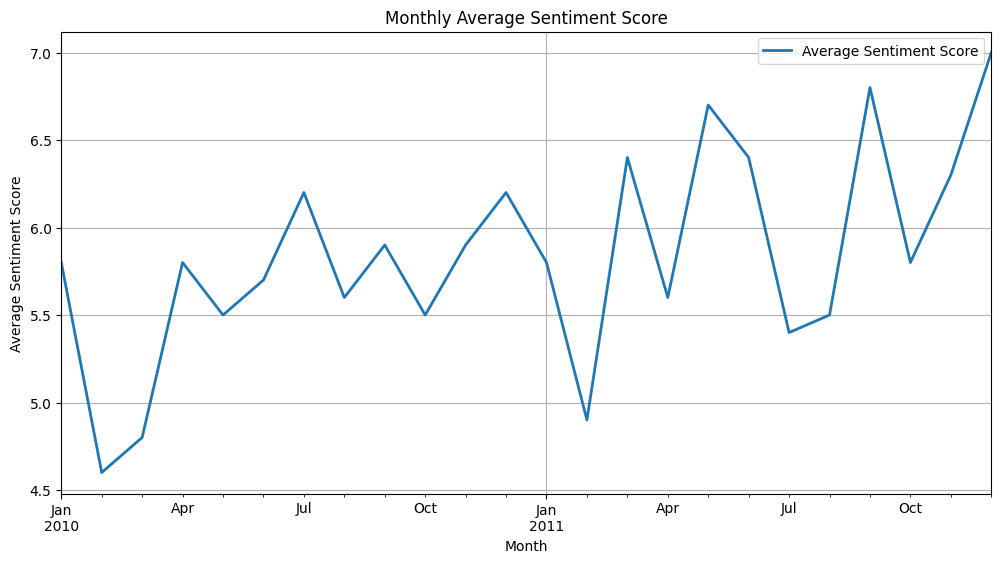

In [55]:
#monthly average sentiment across all employees
monthly_avg = monthly_pivot.groupby(level='date')['Monthly Sentiment Score'].mean()

plt.figure(figsize=(12, 6))
monthly_avg.plot(linestyle='-', linewidth=2, label="Average Sentiment Score")

plt.title("Monthly Average Sentiment Score")
plt.xlabel("Month")
plt.ylabel("Average Sentiment Score")
plt.grid(True)
plt.legend()
plt.savefig("Monthly Average Sentiment Score.png")
plt.show()


### 4. Employee Ranking

In [56]:
#find who has the highest and lowest all time sentiment scores
sentiments_pivot['total sentiment score'] = (sentiments_pivot['Positive'] * 1 + sentiments_pivot['Negative'] * -1)
pos_sentiments_pivot = sentiments_pivot.sort_values(by='total sentiment score', ascending = False)
neg_sentiments_pivot = sentiments_pivot.sort_values(by='total sentiment score', ascending = True)

#print top 3 most positive and negative all time
print('Highest Sentiment Score')
display(pos_sentiments_pivot.head(3))
print('Lowest Sentiment Score')
display(neg_sentiments_pivot.head(3))

Highest Sentiment Score


sentiment,Negative,Neutral,Positive,total sentiment score
from,,,,
lydia.delgado@enron.com,16,64,204,188
john.arnold@enron.com,12,53,191,179
patti.thompson@enron.com,20,38,167,147


Lowest Sentiment Score


sentiment,Negative,Neutral,Positive,total sentiment score
from,,,,
kayne.coulter@enron.com,18,33,123,105
rhonda.denton@enron.com,10,40,122,112
bobette.riner@ipgdirect.com,23,45,149,126


In [57]:
#A funtion to find the highest, and a function to find the lowest sentiment scores for a given month
def top_3_scores(month):
    #access monthly data from the monthly pivot table
    monthly_data = monthly_pivot.xs(month, level='date')
    #get the top 3 for the selected month, sorted by score and alphabetically
    top_3 = monthly_data.sort_values(by=['Monthly Sentiment Score', 'from'], ascending=[False, True]).head(3)
    #put the top 3 emails and scores in a list
    top_3_list = top_3.reset_index()[['from', 'Monthly Sentiment Score']].values.tolist()
    #put the data from the new list into a data frame for readable output
    new_col_name = f'Highest Sentiment Scores ({month})' 
    top_3_df = pd.DataFrame(top_3_list, columns = ['Email Address', new_col_name])
    #I adjust the index so it reflects the ranking
    top_3_df.index = range(1, len(top_3_df) + 1)
    #return the df
    return top_3_df

#and the same for bottom 3
def bottom_3_scores(month):
    monthly_data = monthly_pivot.xs(month, level='date')
    bottom_3 =  monthly_data.sort_values(by=['Monthly Sentiment Score', 'from'], ascending=[True, True]).head(3)
    bottom_3_list = bottom_3.reset_index()[['from', 'Monthly Sentiment Score']].values.tolist()
    new_col_name = f'Lowest Sentiment Scores ({month})'
    bottom_3_df = pd.DataFrame(bottom_3_list, columns=['Email Address', new_col_name])
    bottom_3_df.index = range(1, len(bottom_3_df) + 1)
    return bottom_3_df

In [58]:
#example
example_month = '2010-07'
top_senders_2010_06 = top_3_scores(example_month)
bottom_senders_2010_06 = bottom_3_scores(example_month)

print("Most Positive Employees")
display(top_senders_2010_06)
print("Most Negative Employees")
display(bottom_senders_2010_06)

Most Positive Employees


,Email Address,Highest Sentiment Scores (2010-07)
1,eric.bass@enron.com,16.0
2,lydia.delgado@enron.com,12.0
3,sally.beck@enron.com,9.0


Most Negative Employees


,Email Address,Lowest Sentiment Scores (2010-07)
1,patti.thompson@enron.com,1.0
2,don.baughman@enron.com,2.0
3,johnny.palmer@enron.com,2.0


### 5. Flight Risk Identification

In [59]:
#filter for negative sentiment
neg_df = df[df['sentiment score'] == -1].copy()
#sort by sender and date
neg_df = neg_df.sort_values(['from', 'date'])
#make enpty list to hold info
flight_risk = []
#loop to process each sender individually
for sender, group in neg_df.groupby('from'):
    group = group.copy()    
    #ensure datetime index and sorted
    group = group.set_index('date').sort_index()    
    #add rolling 30 day window on sentiment entries
    group['count_30d'] = (
        group['sentiment score']
        .rolling('30D')
        .count())
    #restore 'date' to a column
    group = group.reset_index()    
    flight_risk.append(group)

#combine all sender groups into one df
rolling_df = pd.concat(flight_risk)
#find suspicious senders with at least 4 negatives in any 30-day window
suspicious_senders = rolling_df[rolling_df['count_30d'] >= 4]['from'].unique()

print("Suspicious senders (>=4 negative messages in any 30-day period):")
print(suspicious_senders)


Suspicious senders (>=4 negative messages in any 30-day period):
['bobette.riner@ipgdirect.com' 'eric.bass@enron.com'
 'john.arnold@enron.com' 'johnny.palmer@enron.com'
 'kayne.coulter@enron.com' 'patti.thompson@enron.com'
 'sally.beck@enron.com']


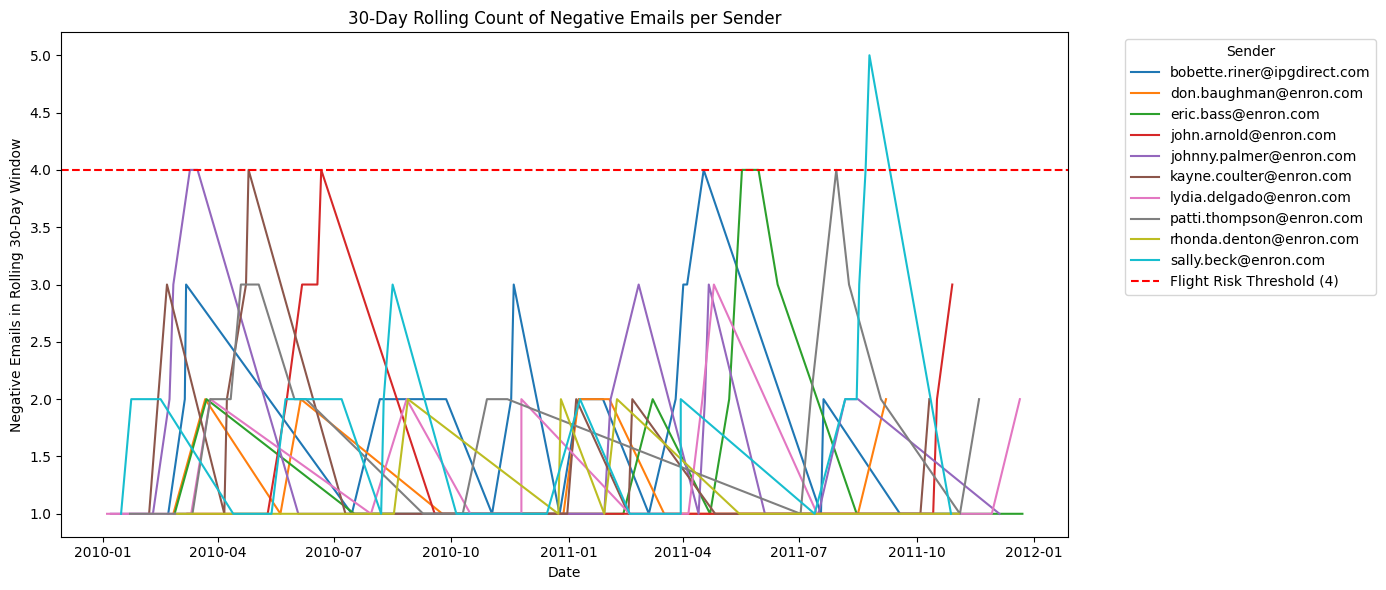

In [60]:
#plot rolling 30 days vs count of negative emails
plt.figure(figsize=(14, 6))
for sender, group in rolling_df.groupby('from'):
    plt.plot(group['date'], group['count_30d'], label=sender)

#show threshold
plt.axhline(4, color='red', linestyle='--', label='Flight Risk Threshold (4)')

#formatting
plt.title('30-Day Rolling Count of Negative Emails per Sender')
plt.xlabel('Date')
plt.ylabel('Negative Emails in Rolling 30-Day Window')
plt.legend(title='Sender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.savefig('flight risk threshold.png')
plt.show()

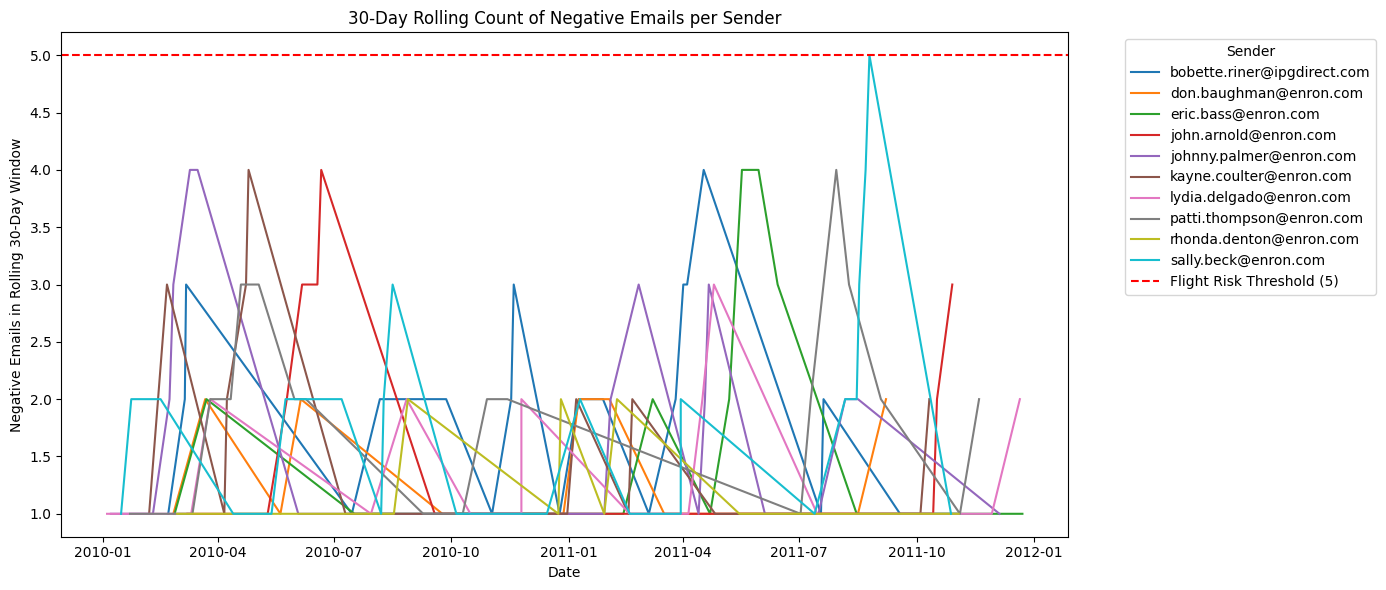

In [61]:
#maybe check a higher threshold to narrow things down a bit
#plot rolling 30 days vs count of negative emails
plt.figure(figsize=(14, 6))
for sender, group in rolling_df.groupby('from'):
    plt.plot(group['date'], group['count_30d'], label=sender)

#show threshold
plt.axhline(5, color='red', linestyle='--', label='Flight Risk Threshold (5)')

#formatting
plt.title('30-Day Rolling Count of Negative Emails per Sender')
plt.xlabel('Date')
plt.ylabel('Negative Emails in Rolling 30-Day Window')
plt.legend(title='Sender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('increased flight risk threshold.png')
plt.show()

### 6. Predictive Modelling

Feature Engineering:

In [62]:
df.head()

,Subject,body,date,from,sentiment,sentiment score
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com,Positive,1
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com,Positive,1
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com,Neutral,0
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com,Neutral,0
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com,Positive,1


In [63]:
#load positive and negative word lists
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

In [64]:
def sentiment_word_percentage(text):
    #tokenize & lowercase text
    words = word_tokenize(text.lower())  
    total_words = len(words)
    
    #count positive & negative words
    pos_count = sum(1 for word in words if word in positive_words)
    neg_count = sum(1 for word in words if word in negative_words)
    
    #get percentages
    pos_percentage = (pos_count / total_words) * 100 if total_words > 0 else 0
    neg_percentage = (neg_count / total_words) * 100 if total_words > 0 else 0

    return pos_percentage, neg_percentage, pos_count, neg_count, total_words

In [65]:
# Apply function to 'Subject' and 'Body' separately
df[['subject_pos_pct', 'subject_neg_pct', 'subject_pos_count', 'subject_neg_count', 'subject_total_words']] = df['Subject'].apply(sentiment_word_percentage).apply(pd.Series)
df[['body_pos_pct', 'body_neg_pct', 'body_pos_count', 'body_neg_count', 'body_total_words']] = df['body'].apply(sentiment_word_percentage).apply(pd.Series)

# Check updated DataFrame
df.head(3)

,Subject,body,date,from,sentiment,sentiment score,subject_pos_pct,subject_neg_pct,subject_pos_count,subject_neg_count,subject_total_words,body_pos_pct,body_neg_pct,body_pos_count,body_neg_count,body_total_words
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com,Positive,1,0.0,0.0,0.0,0.0,3.0,0.877193,0.000000,1.0,0.0,114.0
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com,Positive,1,0.0,0.0,0.0,0.0,4.0,3.030303,1.515152,2.0,1.0,66.0
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com,Neutral,0,0.0,0.0,0.0,0.0,7.0,0.000000,0.000000,0.0,0.0,50.0


In [66]:
monthly_df = df.groupby([df['date'].dt.to_period('M'), 'from']).agg({
    'sentiment score': 'sum',        #total sentiment score
    'subject_pos_pct': 'mean',       #avg positive word percentage in subject
    'subject_neg_pct': 'mean',       #avg negative word percentage in subject
    'subject_pos_count': 'sum',      #total positive words in subject
    'subject_neg_count': 'sum',      #total negative words in subject
    'subject_total_words': 'sum',    #total words in subject
    'body_pos_pct': 'mean',          #avg positive word percentage in body
    'body_neg_pct': 'mean',          #avg negative word percentage in body
    'body_pos_count': 'sum',         #total positive words in body
    'body_neg_count': 'sum',         #total negative words in body
    'body_total_words': 'sum'        #total words in body
}).reset_index()
#add message count per sender per month
monthly_df['message_count'] = df.groupby([df['date'].dt.to_period('M'), 'from']).size().values

monthly_df.head(3)

,date,from,sentiment score,subject_pos_pct,subject_neg_pct,subject_pos_count,subject_neg_count,subject_total_words,body_pos_pct,body_neg_pct,body_pos_count,body_neg_count,body_total_words,message_count
0,2010-01,bobette.riner@ipgdirect.com,1,0.000000,0.0,0.0,0.0,12.0,1.785714,0.000000,1.0,0.0,39.0,2
1,2010-01,don.baughman@enron.com,8,2.777778,0.0,1.0,0.0,32.0,3.632712,0.127714,9.0,1.0,364.0,9
2,2010-01,eric.bass@enron.com,9,0.000000,0.0,0.0,0.0,50.0,2.936861,0.524476,12.0,3.0,444.0,10


In [67]:
#sort by date to ensure correct ordering
monthly_df = monthly_df.sort_values(by='date')
#create a numeric index for months starting at 1, and drop original date column
monthly_df['month_index'] = monthly_df['date'].astype(str).astype('datetime64[ns]').dt.to_period('M').factorize()[0] + 1
#drop non-numeric columns, date has been replaced. 'from' is being dropped to prevent data leakage
monthly_df.drop(columns =['date', 'from'], inplace = True)
monthly_df = monthly_df.rename(columns={'sentiment score': 'monthly sentiment score'})

monthly_df.head(1)

,monthly sentiment score,subject_pos_pct,subject_neg_pct,subject_pos_count,subject_neg_count,subject_total_words,body_pos_pct,body_neg_pct,body_pos_count,body_neg_count,body_total_words,message_count,month_index
0,1,0.0,0.0,0.0,0.0,12.0,1.785714,0.0,1.0,0.0,39.0,2,1


Train Test Split

In [68]:
X = monthly_df.drop(columns=['monthly sentiment score'])
y = monthly_df['monthly sentiment score']

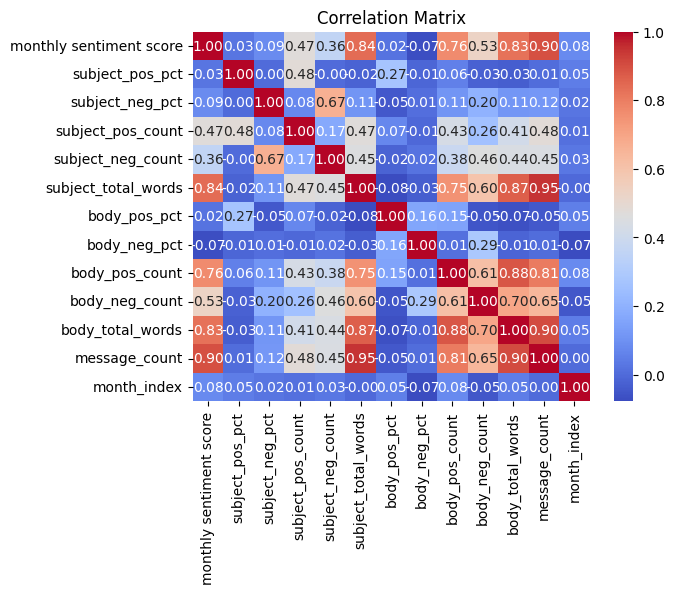

In [69]:
corr_matrix = monthly_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.savefig('correlation_matrix.png')
plt.show()

In [70]:
#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [71]:
#scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Create the model and make predictions

In [72]:
#create linear regression model
model = LinearRegression()

#fit the model to the training data. 
model.fit(X_train_scaled, y_train)

LinearRegression()

In [73]:
#use model to make predictions
predictions = model.predict(X_test_scaled)

In [74]:
#evaluate model
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R2 Score: {r2:.4f}")


Mean Squared Error (MSE): 3.5535
R2 Score: 0.8005


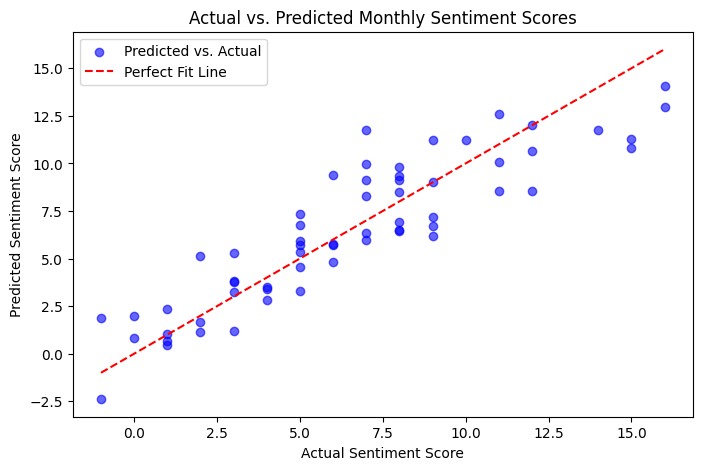

In [75]:
plt.figure(figsize=(8, 5))
plt.scatter(y_test, predictions, color='blue', alpha=0.6, label='Predicted vs. Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='dashed', label='Perfect Fit Line')

# Labels & Titles
plt.xlabel("Actual Sentiment Score")
plt.ylabel("Predicted Sentiment Score")
plt.title("Actual vs. Predicted Monthly Sentiment Scores")
plt.legend()
plt.savefig("Actual vs. Predicted Monthly Sentiment Scores.png")
plt.show()